# Generative probability models for segmenting brain images and better understanding white matter degredation

## Robert Kramer
## Simulation and Modeling with R or Python
### 15 June 2017

There are several methods for segmenting MRI data. Generative probability models of the images may enable better segmentation by being able to simulate data. We can compare the simulated data to images and decide the structure of the brain matter based on it's similarity to the simulated (generated) data. Stocastic techniques like MCMC are common and effective, but can be computationally intensive. I propose simulating data based on an empirical distribution across pixels as well as a model assuming a guassian across (x, y) coordinates, and a univariate normal for greyscale value. 

In [57]:
from PIL import Image
from scipy import stats
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import os

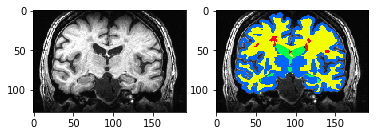

In [58]:
im_lisa = mpimg.imread("./data/001_4.bmp")
plt.subplot(121)
plt.imshow(im_lisa)
im_seg_lisa = mpimg.imread("./data/001_4_seg.bmp")
plt.subplot(122)
plt.imshow(im_seg_lisa)
plt.show()

Actual Image vs Hand segmented image

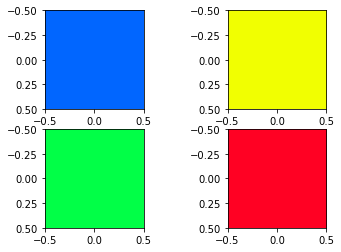

In [59]:
# getting one pixel
plt.subplot(221)
plt.imshow(im_seg_lisa[80:81, 50:51]) 
# Blue [1, 102, 255] grey matter (1)
plt.subplot(222)
plt.imshow(im_seg_lisa[85:86, 50:51]) 
# Yellow [241, 255, 1] white matter (2)
plt.subplot(223)
plt.imshow(im_seg_lisa[50:51, 80:81]) 
# Green array([[[  1, 255,  71]]], dtype=uint8) csf (3)
plt.subplot(224)
plt.imshow(im_seg_lisa[33:34, 70:71])
# Red array([[[255,   1,  35]]], dtype=uint8) disease (4)
plt.show()

1. grey matter
2. white matter
3. csf
4. disease

In [60]:
def get_image_data(image, seg_image):
    '''
    Turns everything black that is not segmented.
    Works for lisa's data
    
    The image is greyscale so channels are equal
        We only need 1 number to represent all of it
    
    '''
    crds = [] # saves a tuple ((x,y),lable)
    neighbors = [] # saves pixel value of neighbors for EM
    for i in range(len(seg_image)):
        for j in range(len(seg_image[1])):
            if tuple(seg_image[i,j]) == (1, 102, 255):
                crds.append((i,j,image[i,j][0],1)) # one value grayscale
                # grey matter
                neighbors.append((im_lisa[(i-3):(i+2),(j-3):(j+2),1].reshape((1,25)),1))
                # [sub for each in im[(i-3):(i+2),(j-3):(j+2),1] for sub in each]
            elif tuple(seg_image[i,j]) == (241, 255, 1):
                crds.append((i,j,image[i,j][0],2))
                # white
                neighbors.append((im_lisa[(i-3):(i+2),(j-3):(j+2),1].reshape((1,25)),2))
            elif tuple(seg_image[i,j]) == (1, 255, 71):
                crds.append((i,j,image[i,j][0],3))
                # csf
                neighbors.append((im_lisa[(i-3):(i+2),(j-3):(j+2),1].reshape((1,25)),3))
            elif tuple(seg_image[i,j]) == (255, 1, 35):
                crds.append((i,j,image[i,j][0],4))
                # disease
                neighbors.append((im_lisa[(i-3):(i+2),(j-3):(j+2),1].reshape((1,25)),4))
            else:
                seg_image[i,j] = 1
                image[i,j] = 1
    coords = np.empty((len(crds),4))
    neighbors_data = np.empty((len(crds),26))
    for i in range(len(crds)):
        coords[i] = crds[i]
        neighbors_data[i] = np.append(neighbors[i][0],neighbors[i][1])
    return coords.astype(int), neighbors_data.astype(int)

In [61]:
data_test, neighbors_d = get_image_data(im_lisa, im_seg_lisa)

Now the images have black backgrounds

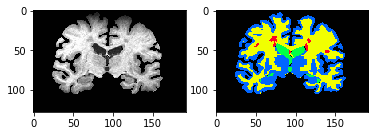

In [62]:
plt.subplot(121)
plt.imshow(im_lisa)
plt.subplot(122)
plt.imshow(im_seg_lisa)
plt.show()

In [63]:
def get_all_data():
    directory = os.fsencode("./data")
    image_names = []
    seg_image_names = []
    images = []
    images_seg = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if filename.endswith(".bmp"): 
            if filename.endswith("seg.bmp"): 
                seg_image_names.append(filename)
            else:
                image_names.append(filename)
        else:
            continue
    images.append(mpimg.imread("./data/"+image_names[0]))
    images_seg.append(mpimg.imread("./data/"+seg_image_names[0]))
    data_coord, data_neigh = get_image_data(images[0], images_seg[0])
    for i in range(1,len(image_names)):
        images.append(mpimg.imread("./data/"+image_names[i])) 
        images_seg.append(mpimg.imread("./data/"+seg_image_names[i]))
        data_coord1, data_neigh1 = get_image_data(images[i], images_seg[i])
        data_coord = np.append(data_coord, data_coord1,0)
        data_neigh = np.append(data_neigh, data_neigh1,0)
    return data_coord, data_neigh, images, images_seg

data_coord, data_neigh, images, images_seg = get_all_data()

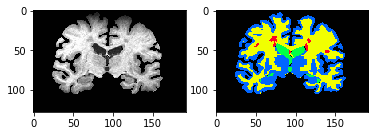

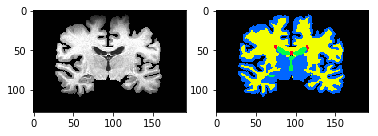

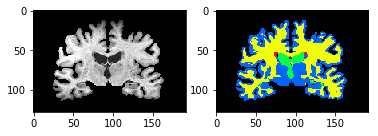

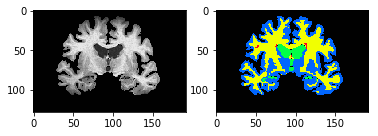

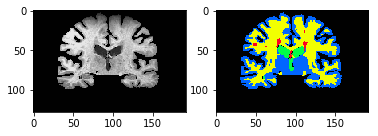

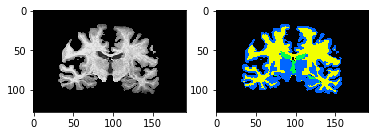

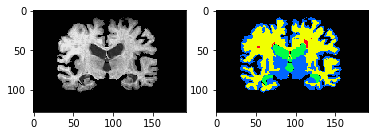

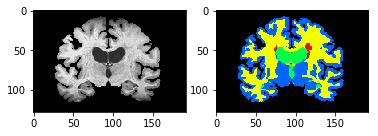

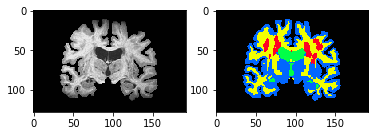

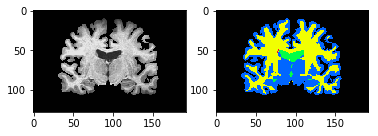

In [64]:
for i in range(len(images)):
    plt.subplot(1,2,1)
    plt.imshow(images[i])
    plt.subplot(1,2,2)
    plt.imshow(images_seg[i])
    plt.show()

# Exploring the properties of each segmentation

## Grey Matter

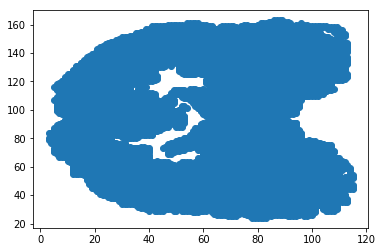

In [65]:
data = data_coord[:]

grey_cluster = data[data[:,3]==1]

plt.scatter(grey_cluster[:,0],grey_cluster[:,1])

plt.show()

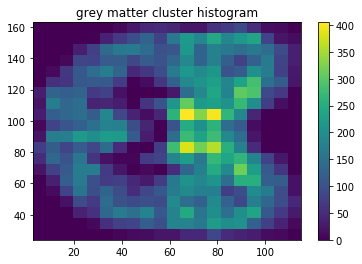

In [66]:
plt.hist2d(grey_cluster[:,0],grey_cluster[:,1], bins=20)
plt.colorbar()
plt.title("grey matter cluster histogram")
plt.show()

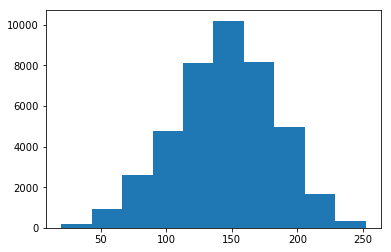

In [67]:
plt.hist(grey_cluster[:,2])
plt.show()

In [68]:
grey_cluster_mu = np.mean(grey_cluster[:,2])
grey_cluster_var = np.var(grey_cluster[:,2])


## White Matter

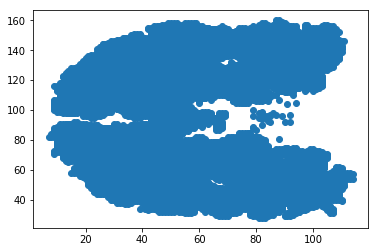

In [69]:
white_cluster = data[data[:,3]==2]

plt.scatter(white_cluster[:,0],white_cluster[:,1])
plt.show()

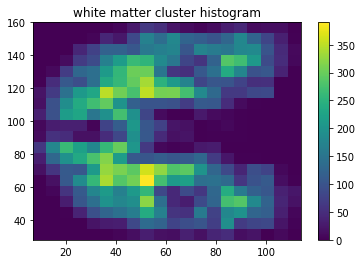

In [70]:
plt.hist2d(white_cluster[:,0],white_cluster[:,1], bins=20)
plt.colorbar()
plt.title("white matter cluster histogram")
plt.show()

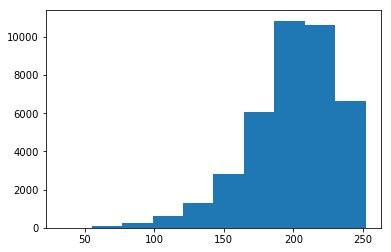

In [71]:
plt.hist(white_cluster[:,2])
plt.show()

In [72]:
white_cluster_mu = np.mean(white_cluster[:,2])
white_cluster_var = np.var(white_cluster[:,2])

# csf

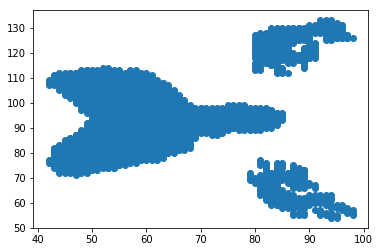

In [73]:
csf_cluster = data[data[:,3]==3]

plt.scatter(csf_cluster[:,0],csf_cluster[:,1])
plt.show()

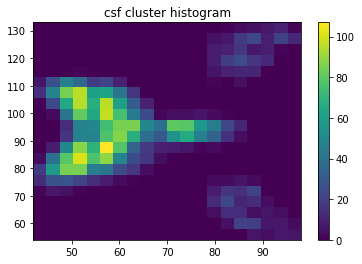

In [74]:
plt.hist2d(csf_cluster[:,0],csf_cluster[:,1], bins=20)
plt.colorbar()
plt.title("csf cluster histogram")
plt.show()

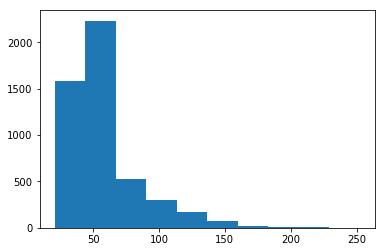

In [75]:
plt.hist(csf_cluster[:,2])
plt.show()

In [76]:
csf_cluster_mu = np.mean(csf_cluster[:,2])
csf_cluster_var = np.var(csf_cluster[:,2])

# Diseased Cluster

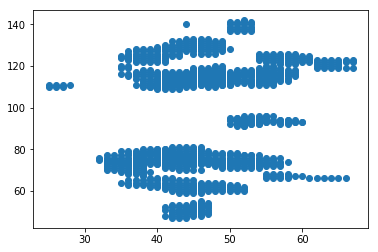

In [77]:
disease_cluster = data[data[:,3]==4]

plt.scatter(disease_cluster[:,0],disease_cluster[:,1])
plt.show()

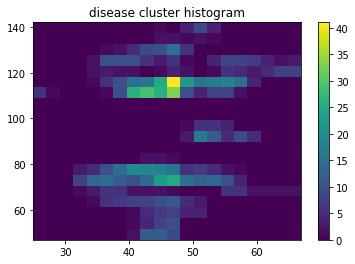

In [78]:
plt.hist2d(disease_cluster[:,0],disease_cluster[:,1], bins=20)
plt.colorbar()
plt.title("disease cluster histogram")
plt.show()

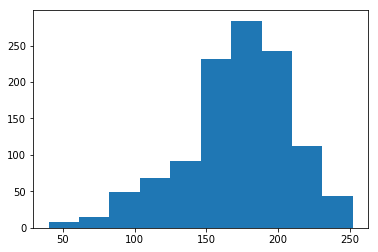

In [79]:
plt.hist(disease_cluster[:,2])

disease_cluster_mu = np.mean(disease_cluster[:,2])
disease_cluster_var = np.var(disease_cluster[:,2])
plt.show()

## Use symmetry to transform the position data into something that could be normal

In [80]:
reflection  = np.array([[-1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,1]])
test = data - [0,np.mean(data[:,1]),0,0]

test[:,1] = np.absolute(test[:,1])

grey_cluster = test[test[:,3]==1]




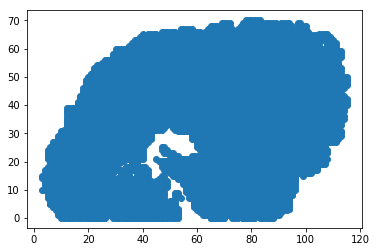

In [81]:
plt.scatter(grey_cluster[:,0],grey_cluster[:,1])
plt.show()

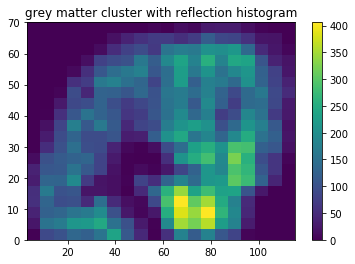

In [82]:
plt.hist2d(grey_cluster[:,0],grey_cluster[:,1], bins=20)
plt.colorbar()
plt.title("grey matter cluster with reflection histogram")
plt.show()

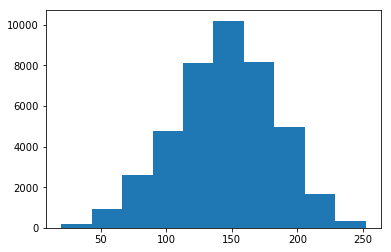

In [83]:
plt.hist(grey_cluster[:,2])
plt.show()

## Generate data with mixture probability model

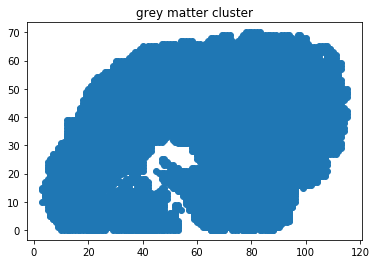

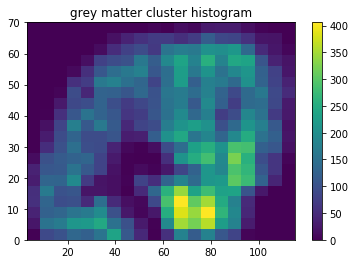

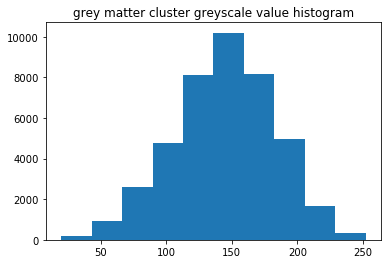

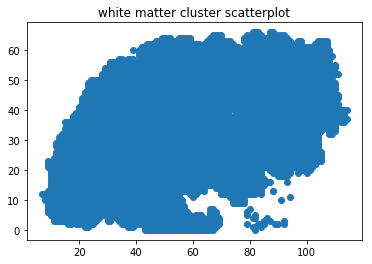

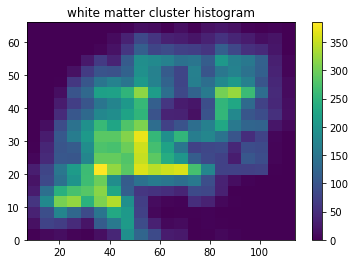

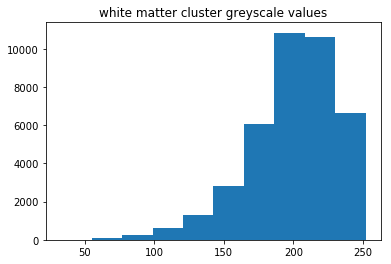

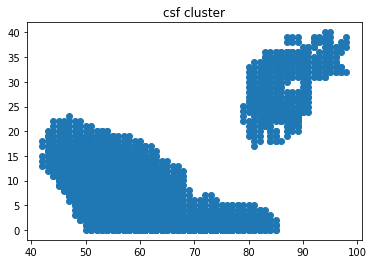

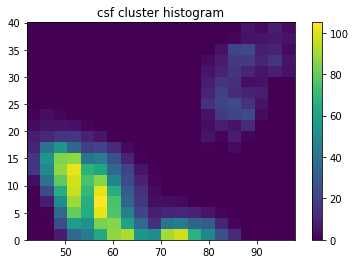

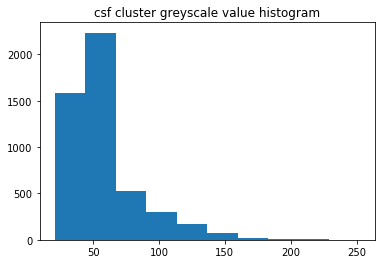

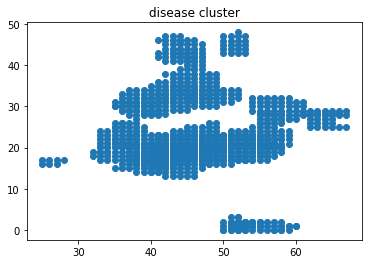

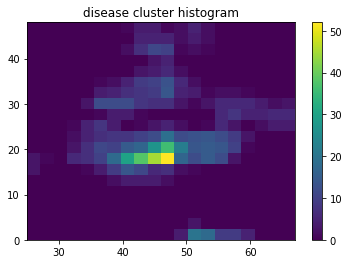

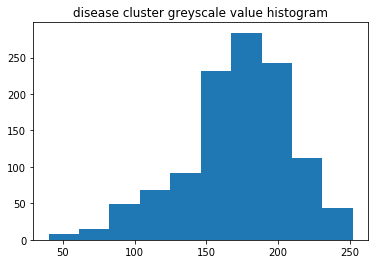

In [84]:
data = data - [0,np.mean(data[:,1]),0,0]

data[:,1] = np.absolute(test[:,1])

grey_cluster = data[data[:,3]==1]

plt.subplots()
plt.scatter(grey_cluster[:,0],grey_cluster[:,1])
plt.title("grey matter cluster")
plt.show()

plt.subplots()
plt.hist2d(grey_cluster[:,0],grey_cluster[:,1], bins=20)
plt.colorbar()
plt.title("grey matter cluster histogram")
plt.show()

plt.subplots()
plt.hist(grey_cluster[:,2])
plt.title("grey matter cluster greyscale value histogram")
plt.show()

grey_cluster_mu = np.mean(grey_cluster[:,2])
grey_cluster_var = np.var(grey_cluster[:,2])

white_cluster = data[data[:,3]==2]

plt.subplots()
plt.scatter(white_cluster[:,0],white_cluster[:,1])
plt.title("white matter cluster scatterplot")
plt.show()

plt.subplots()
plt.hist2d(white_cluster[:,0],white_cluster[:,1], bins=20)
plt.colorbar()
plt.title("white matter cluster histogram")
plt.show()

plt.subplots()
plt.hist(white_cluster[:,2])
plt.title("white matter cluster greyscale values")
plt.show()

white_cluster_mu = np.mean(white_cluster[:,2])
white_cluster_var = np.var(white_cluster[:,2])

csf_cluster = data[data[:,3]==3]

plt.subplots()
plt.scatter(csf_cluster[:,0],csf_cluster[:,1])
plt.title("csf cluster")
plt.show()

plt.subplots()
plt.hist2d(csf_cluster[:,0],csf_cluster[:,1], bins=20)
plt.colorbar()
plt.title("csf cluster histogram")
plt.show()

plt.subplots()
plt.hist(csf_cluster[:,2])
plt.title("csf cluster greyscale value histogram")
plt.show()


csf_cluster_mu = np.mean(csf_cluster[:,2])
csf_cluster_var = np.var(csf_cluster[:,2])

disease_cluster = data[data[:,3]==4]

#plt.subplots()
plt.scatter(disease_cluster[:,0],disease_cluster[:,1])
plt.title("disease cluster")
plt.show()


plt.hist2d(disease_cluster[:,0],disease_cluster[:,1], bins=20)
plt.colorbar()
plt.title("disease cluster histogram")
plt.show()

plt.hist(disease_cluster[:,2])
plt.title("disease cluster greyscale value histogram")
plt.show()



disease_cluster_mu = np.mean(disease_cluster[:,2])
disease_cluster_var = np.var(disease_cluster[:,2])

Simulate some data with the model

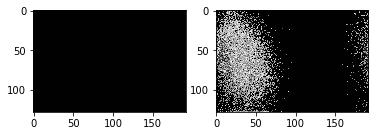

In [107]:
N = 20000
K = 4
pi = [len(grey_cluster)/len(data),len(white_cluster)/len(data),
      len(csf_cluster)/len(data),len(disease_cluster)/len(data)]
means = [grey_cluster_mu, white_cluster_mu, csf_cluster_mu, disease_cluster_mu]
sigs = [grey_cluster_var, white_cluster_var, csf_cluster_var, disease_cluster_var]




#z_inter = np.zeros((N,K),dtype=int)
#for i in range(len(z)):
#    z_inter[i][z[i]]=1
#z = z_inter

muX1 = np.mean(grey_cluster,0)[0:2]
muX2 = np.mean(white_cluster,0)[0:2]
muX3 = np.mean(csf_cluster,0)[0:2]
muX4 = np.mean(disease_cluster,0)[0:2]

covX1 = np.cov(grey_cluster[:,0:2].T)
covX2 = np.cov(white_cluster[:,0:2].T)
covX3 = np.cov(csf_cluster[:,0:2].T)
covX4 = np.cov(disease_cluster[:,0:2].T)

mus = [muX1, muX2, muX3, muX4]
covs = [covX1, covX2, covX3, covX4]

z = np.random.choice(range(4),size=N,p=pi)

sim_data = np.zeros((N,3))


# you still need to handle the reflection
for i in range(N):
    sim_data[i,0:2] = np.random.multivariate_normal(mus[z[i]],covs[z[i]] ,size=1)
    if sim_data[i,0] > 127:
        sim_data[i,0] = 127
    elif sim_data[i,1] > 191:
        sim_data[i,1] = 191
    sim_data[i,2] = np.random.normal(means[z[i]],np.sqrt(sigs[z[i]]),1)


sim_data = np.round(sim_data).astype(int)

im_test = im_lisa
im_test[:,:]=1
plt.subplot(121)
plt.imshow(im_test)
for i in range(N):
    im_test[sim_data[i][0], sim_data[i][1]] = sim_data[i][2]

    

plt.subplot(122)
plt.imshow(im_test)
plt.show()

Simulated data represents all the types of data for half of the brain reflected about the y axis at the mean.

Translating the data to the middle and reflecting it for symmetry

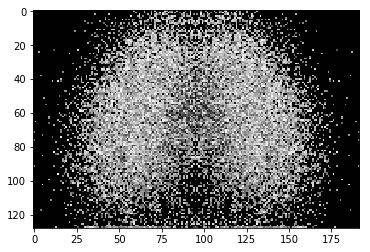

In [108]:
# recenter
sim_data1 = sim_data[:] 
sim_data1 = sim_data1 + np.array((0,95,0)).astype(int)
sim_data1 = np.round(sim_data1).astype(int)

reflection  = np.array([[1,0,0],[0,-1,0],[0,0,1]])
sim_data_reflection  = sim_data[:] @ reflection
sim_data_reflection = sim_data_reflection + np.array((0,95,0)).astype(int)


im_test = im_lisa
im_test[:,:]=1
for i in range(N):
    if sim_data1[i,0] > 127:
        sim_data1[i,0] = 127
    elif sim_data1[i,1] > 191:
        sim_data1[i,1] = 191
    im_test[sim_data1[i][0], sim_data1[i][1]] = sim_data1[i][2]
for i in range(N):
    if sim_data_reflection[i,0] > 127:
        sim_data_reflection[i,0] = 127
    elif sim_data_reflection[i,1] < 0:
        sim_data_reflection[i,1] = 0
    im_test[sim_data_reflection[i][0], sim_data_reflection[i][1]] = sim_data_reflection[i][2]

plt.imshow(im_test)
plt.show()


Now I want to map a conditional distripution based on the coordinates or $$P(brain \ structure | (x, y), \ greyscale \ value)$$

I tried some simple things, but it's more complicated than I expected and I'm going to finish here.

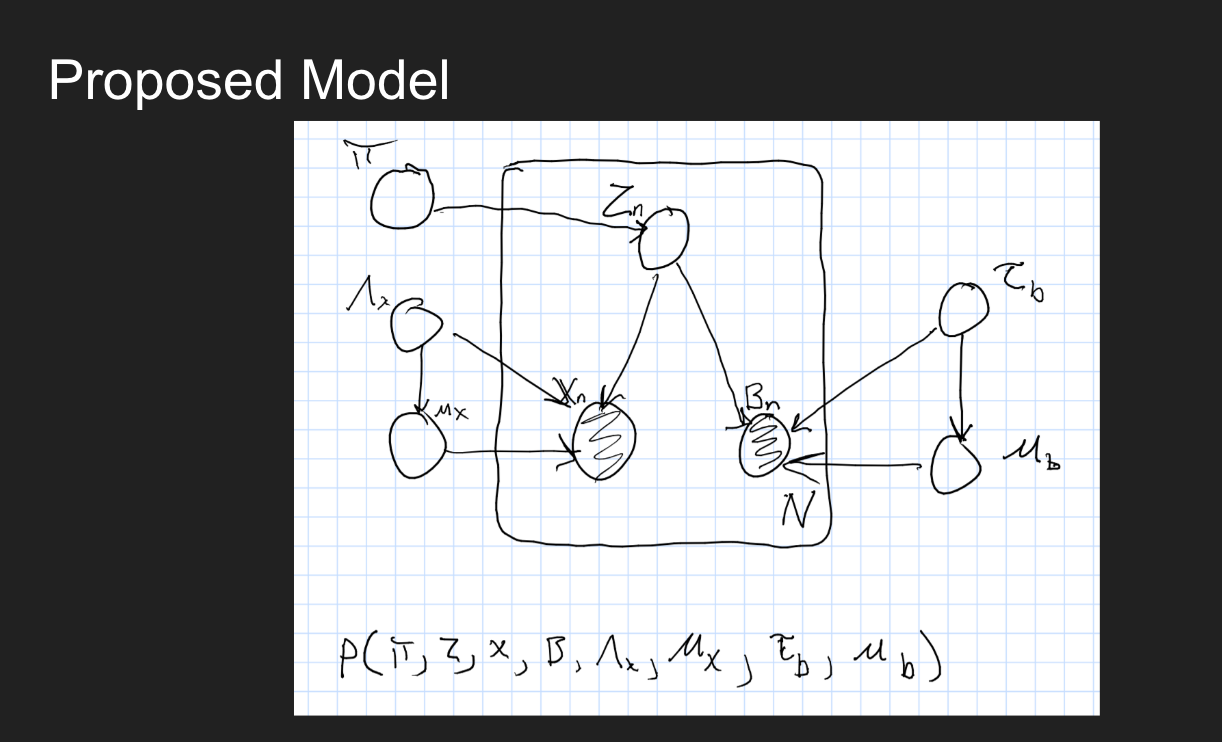

In [109]:
from IPython.display import Image
Image(filename="bayesModel.png")


# Conclusion



I used a novel graphical model to stocastically simulate MRI data. The model has the benefit of being mathematically tractable for use in bayesian inference of the cluster values. However, the structure of the brain wasn't really captured by the simulated data. I believe the indepent assumption and the slight differences in the placement of the images lead to the inability of the model to capture the structure. I have some ideas of how to incorporate the prior information in the future. I would also like to model the degredation of white matter with an agent based model in the future. Perhaps these models could be used to find problems sooner or better understand these diseases and aging.
